# Setup





In [1]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Navigate to folder containing project
import os
os.chdir("drive/My Drive/COMP 551/Projects/Project3")

In [0]:
from google.colab.patches import cv2_imshow
# Function to show a single image 
def show_single_picture(img):
    """ Plot an image """
    cv2_imshow(img*255)

# VGG16


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import datetime
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.model_selection import train_test_split

# Using pre-trained models
from keras.applications import VGG16, VGG19, InceptionResNetV2, Xception, NASNetLarge
from keras import datasets, optimizers
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
# Read data 
x_train = pd.read_pickle("data/x_train.pkl")
x_valid = pd.read_pickle("data/x_valid.pkl")
y_train = pd.read_pickle("data/y_train.pkl")
y_valid = pd.read_pickle("data/y_valid.pkl")

# Convert training/valid images from grayscale to rgb (3 channels)
x_train = np.stack((x_train,x_train,x_train), axis=-1)
x_valid = np.stack((x_valid,x_valid,x_valid), axis=-1)

# Image dimensions 
image_size = x_train[0].shape[0]
num_channels = x_train[0].shape[2]
print("Image size: {0}\nNumber of channels: {1}".format(image_size, num_channels))

Image size: 128
Number of channels: 3


**The goal when applying data augmentation is to increase the generalizability of the model.**
Given that our network is constantly seeing new, slightly modified versions of the input data, the network is able to learn more robust features.

Reasons to use a data generator
- Real-world datasets are often too large to fit into memory.
- They also tend to be challenging, requiring us to perform data augmentation to avoid overfitting and increase the ability of our model to generalize.

Here's how the ImageDataGenerator works:
1. Accepting a batch of images used for training.
2. Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
3. Replacing the **original** batch with the **new, randomly transformed batch**.
4. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

Keras' ImageDataGenerator executes in-place data augmentation. 
It is called "in-place" and "on-the-fly", because data augmentation is done at training time. 
If we included the original training data along with the augmented data in each batch, then the network would “see” the original training data multiple times, effectively defeating the purpose.
The entire point of the data augmentation technique described in this section is to ensure that the network sees “new” images that it has never "seen" before at each and every epoch.
To accomplish this goal we “replace” the training data with randomly transformed, augmented data.
Performing data augmentation is a form of regularization, enabling our model to generalize better. 

NOTE: we don't apply data augmentation to validation/test data, therefore we don't need a generator.

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [0]:
# Construct the training image generator to perform data augmentation (NOTE: since we are working numbers, it is important to set the rotation and the horizontal_flip to 0 and False respectively).
datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.10,
	width_shift_range=0.05, height_shift_range=0.05, shear_range=0,
	horizontal_flip=False,vertical_flip=False, fill_mode="nearest")

In [0]:
# Fit data generator on training data for ZCA whitening
datagen.fit(x_train)

In [0]:
# Verify image generated by ImageDataGenerator
for i in  datagen.flow(x=x_train,y=y_train)[0][0]:
  show_single_picture(i)

In [0]:
# Initialize number of epochs, batch_size and validation split 
WARMUP = 5
EPOCHS = 30
batch_size = 64

In [0]:
# Initialize optimizer
learning_rate = 1e-3
optimizer = optimizers.SGD(lr=learning_rate, momentum=0.9) 

**Fine Tune Pre-Trained Models**

In [0]:
# Create a model using pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_size, image_size, num_channels)), pooling='avg') # assumes data_format = "channels_last"

# Add a global spatial average pooling layer
top_network = base_model.output
# Add a fully-connected layer    
top_network = Dense(128, activation='relu')(top_network)
# Add a Dropout layer
top_network = Dropout(0.25)(top_network)
# Add a fully-connected layer    
top_network = Dense(64, activation='relu')(top_network)
# Add a logistic layer with 10 classes
top_network = Dense(10, activation='softmax')(top_network)

# Create model
model = Model(inputs=base_model.input, outputs=top_network)

# Step 1: Train only the top layers (i.e. fully connected layers) which were randomly initialized. Freeze all VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Display trainable layers
for layer in model.layers:
  print("{}: {}".format(layer, layer.trainable))

# Compile the model (should be done ***after*** setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Print a summary of the model
model.summary()

# Train the head of the network on new data for a few epochs (all other layers are frozen) -- this will allow the new FC layers to start to become initialized with actual "learned" values versus pure random
history = model.fit_generator(datagen.flow(x=x_train, y=y_train, batch_size=batch_size), validation_data=(x_valid,y_valid), steps_per_epoch=len(x_train)//batch_size, epochs=WARMUP)

<keras.engine.input_layer.InputLayer object at 0x7f0275b20278>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275b205f8>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275b20320>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f0275b273c8>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275b2eb00>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275b33c18>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f0275b3aa90>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275b479b0>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275b4d278>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275b535f8>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f0275b5b9b0>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275ae78d0>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275ae7f28>: False
<keras.layers.convolutional.Conv2D object at 0x7f0275af4128>: False
<keras.layers.pooling.MaxPooling2D object at 0

In [0]:
# Save model with FC layer adapted to modified mnist dataset
model.save("models/VGG16_fully_connected_layer_trained_avgpool_128_025_64_10.h5")

In [9]:
# Load model with FC layer adapted to modified mnist dataset
from keras.models import load_model 
model = load_model("models/InceptionResNetV2_final.h5")

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='plots/InceptionResNetV2_architecture.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from VGG16. 

In [0]:
# Visualize layer names and layer indices to see how many layers we should unfreeze for VGG16
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 global_average_pooling2d_3 False
20 dense_4 True
21 dropout_2 True
22 dense_5 True
23 dense_6 True


In [0]:
# Unfreeze all CONV layers in the base model
for layer in model.layers[1:]:
  layer.trainable = True

# Display trainable layers
for layer in model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f027503dbe0>: False
<keras.layers.convolutional.Conv2D object at 0x7f027503dc50>: True
<keras.layers.convolutional.Conv2D object at 0x7f027503de80>: True
<keras.layers.pooling.MaxPooling2D object at 0x7f02750410f0>: True
<keras.layers.convolutional.Conv2D object at 0x7f0275041198>: True
<keras.layers.convolutional.Conv2D object at 0x7f0275041320>: True
<keras.layers.pooling.MaxPooling2D object at 0x7f02750414a8>: True
<keras.layers.convolutional.Conv2D object at 0x7f0275041550>: True
<keras.layers.convolutional.Conv2D object at 0x7f02750416d8>: True
<keras.layers.convolutional.Conv2D object at 0x7f0275041860>: True
<keras.layers.pooling.MaxPooling2D object at 0x7f02750419e8>: True
<keras.layers.convolutional.Conv2D object at 0x7f0275041a90>: True
<keras.layers.convolutional.Conv2D object at 0x7f0275041c18>: True
<keras.layers.convolutional.Conv2D object at 0x7f0275041da0>: True
<keras.layers.pooling.MaxPooling2D object at 0x7f0275041f28

In [0]:
# Recompile the model for these modifications to take effect. SGD is used with a low learning rate to fine tune.
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Print a summary of the model
model.summary()

# Train model again (this time fine-tuning all VGG blocks alongside the top Dense layers)
history = model.fit_generator(datagen.flow(x=x_train, y=y_train, batch_size=batch_size), validation_data=(x_valid,y_valid), steps_per_epoch=len(x_train)//batch_size, epochs=EPOCHS)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [0]:
# Save the model
model.save('models/VGG16_{0}_avgpool_sgd_lr{1}_{2}epochs_bs{3}.h5'.format(max(history.history['val_acc']), learning_rate, EPOCHS, batch_size))

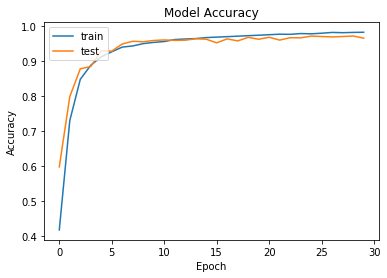

In [0]:
# Plot history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/VGG16_{0}acc_sgd_lr{1}_{2}epochs_bs{3}.png'.format(max(history.history['val_acc']), learning_rate, EPOCHS, batch_size))
plt.show()

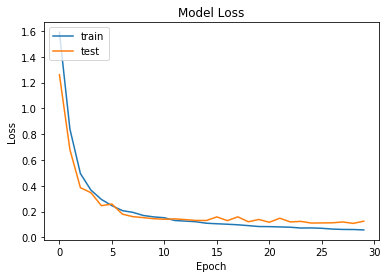

In [0]:
# Plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/VGG16_{0}loss_sgd_lr{1}_{2}epochs_bs{3}.png'.format(min(history.history['val_loss']), learning_rate, EPOCHS, batch_size))
plt.show()

In [0]:
# Load full dataset to train final model 
x_train = pd.read_pickle("data/preprocessed_train_max_x.pkl")
y_train = pd.read_csv("data/train_max_y.csv")["Label"]

# Transform data from grayscale to rgb (3 channels)
x_train = np.stack((x_train,x_train,x_train), axis=-1)

# Load final model
from keras.models import load_model
model = load_model("models/VGG16_sgd0.9737_learning_rate0.0005.h5")

# Fit on entire dataset
history = model.fit_generator(datagen.flow(x=x_train, y=y_train, batch_size=batch_size), steps_per_epoch=len(x_train)//batch_size, epochs=EPOCHS)

Epoch 1/30
195/195 [==============================] - 133s 682ms/step - loss: 0.0737 - acc: 0.9841
Epoch 2/30
195/195 [==============================] - 129s 664ms/step - loss: 0.0685 - acc: 0.9842
Epoch 3/30
195/195 [==============================] - 130s 667ms/step - loss: 0.0621 - acc: 0.9856
Epoch 4/30
195/195 [==============================] - 130s 668ms/step - loss: 0.0617 - acc: 0.9857
Epoch 5/30
195/195 [==============================] - 129s 662ms/step - loss: 0.0589 - acc: 0.9859
Epoch 6/30
195/195 [==============================] - 130s 668ms/step - loss: 0.0539 - acc: 0.9864
Epoch 7/30
195/195 [==============================] - 130s 667ms/step - loss: 0.0529 - acc: 0.9871
Epoch 8/30
195/195 [==============================] - 129s 664ms/step - loss: 0.0515 - acc: 0.9874
Epoch 9/30
195/195 [==============================] - 130s 666ms/step - loss: 0.0507 - acc: 0.9878
Epoch 10/30
195/195 [==============================] - 129s 663ms/step - loss: 0.0503 - acc: 0.9878
Epoch 11/

In [0]:
# Save final model 
model.save('models/VGG16_final.h5')

In [0]:
def predict(model):
  """Method that takes as input a model and stores its predictions in a csv file."""
  import datetime

  test_img = pd.read_pickle("data/preprocessed_test_max_x.pkl")

  # Convert tests images from grayscale to rgb (3 channels)
  test_img = np.stack((test_img,test_img,test_img), axis=-1)

  # Predict 
  preds = model.predict(test_img).argmax(axis=-1)

  # Create DataFrame with predictions
  df = pd.DataFrame({"Id": list(range(len(preds))), "Label": preds})

  # Save predictions 
  df.to_csv("predictions/predictions{}.csv".format(datetime.datetime.now()), index=False)

  return preds 

In [0]:
# Generate predictions
preds = predict(model)

# Handmade Model

In [0]:
def create_model():
    """ Function that returns a model """
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3,3), input_shape=(image_size, image_size, num_channels),activation='relu', data_format="channels_last"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu', data_format="channels_last"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))
    model.add(layers.Conv2D(64, (3,3), activation='relu', data_format="channels_last"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))
    model.add(layers.Conv2D(32, (3,3), activation='relu', data_format="channels_last"))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.20))
    model.add(layers.Dense(10, activation='softmax'))
    
    # Print a summary of the model
    model.summary()

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def predict(model):
    """ Method that takes as input a pretrained model """
    # Read test data 
    x_test = pickle.load(open('preprocessed_test_max_x.pkl', 'rb'))

    # Reshape test 
    x_test = x_test.reshape(x_test.shape[0],128,128,1)
    
    # Predict
    predictions = model.predict(x_test)
    print(predictions)
    
    # Store predictions
    pickle.dump(predictions, open("predictions{}.pkl".format(datetime.datetime.now()),"wb"))
    
def plot_accuracy(history):
  plt.figure(figsize=(15,15))
  plt.plot(history.history['acc'], label='accuracy')
  plt.plot(history.history['val_acc'], label = 'val_accuracy')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.ylim([0.5,1])
  plt.legend(loc=0)
  plt.savefig("plots/train_val_accuracy{}.png".format(datetime.datetime.now()))
  plt.show()

In [0]:
# Instantiate model
model = create_model()

# Train model 
history = model.fit(x=x_train,y=y_train,epochs=EPOCHS,batch_size=batch_size,validation_split=validation_split)

In [0]:
# Save the model
model.save('models/model{}.h5'.format(history.history.get('val_acc')[-1]))

In [0]:
# Produce predictions
predict(model)

In [0]:
# Load predictions 
preds = pickle.load(open("predictions2019-10-28 05:51:28.447014.pkl", "rb"))
print(preds[0])